In [ ]:
import zipfile
zipfile.ZipFile('/content/FS2K.zip', 'r').extractall('/content/FS2K1/')

In [ ]:
!pip install rarfile

In [ ]:
import rarfile

rf = rarfile.RarFile('/content/Checkpoint21.rar')
rf.extractall('/content/Checkpoint21/')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
import re
from pathlib import Path
from sklearn.model_selection import train_test_split

photos_root = Path("FS2K1/FS2K/photo")
sketches_root = Path("FS2K1/FS2K/sketch")
output_root = Path("FS2K")

for split in ["train", "val"]:
    (output_root / split / "photos").mkdir(parents=True, exist_ok=True)
    (output_root / split / "sketches").mkdir(parents=True, exist_ok=True)

def extract_number(fn):
    m = re.search(r'(\d+)', fn)
    return m.group(1) if m else None

def load_all_pairs(sk_root, ph_root):
    pairs = []
    for p_sub in sorted(os.listdir(ph_root)):
        p_dir = os.path.join(ph_root, p_sub)
        if not os.path.isdir(p_dir):
            continue
        num = extract_number(p_sub)
        if not num:
            continue
        s_dir = os.path.join(sk_root, f"sketch{num}")
        if not os.path.isdir(s_dir):
            continue
        photos = {
            extract_number(f): f for f in os.listdir(p_dir)
            if extract_number(f) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        }
        sketches = {
            extract_number(f): f for f in os.listdir(s_dir)
            if extract_number(f) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))
        }
        for n in sorted(set(photos) & set(sketches)):
            sk_path = os.path.join(s_dir, sketches[n])
            ph_path = os.path.join(p_dir, photos[n])
            pairs.append((ph_path, sk_path))
    return pairs

paired_data = load_all_pairs(sketches_root, photos_root)

train_pairs, val_pairs = train_test_split(paired_data, test_size=0.2, random_state=42)

def copy_pairs(pairs, split):
    for idx, (photo_src, sketch_src) in enumerate(pairs, 1):
        photo_dst = output_root / split / "photos" / f"photo{idx:04}.jpg"
        sketch_dst = output_root / split / "sketches" / f"sketch{idx:04}.jpg"
        shutil.copy(photo_src, photo_dst)
        shutil.copy(sketch_src, sketch_dst)

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs, "val")

print(f"Copied {len(train_pairs)} training pairs and {len(val_pairs)} validation pairs.")

Copied 1683 training pairs and 421 validation pairs.


In [ ]:
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode="train"):
        self.transform = transforms_
        self.files_A = sorted(glob.glob(os.path.join(root, "photos") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "sketches") + "/*.*"))
        self.len_A = len(self.files_A)
        self.len_B = len(self.files_B)

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % self.len_A]).convert("RGB")
        img_B = Image.open(self.files_B[index % self.len_B]).convert("RGB")
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}

    def __len__(self):
        return max(self.len_A, self.len_B)

transformations = transforms.Compose([
    transforms.Resize(int(256 * 1.12), Image.BICUBIC),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset_root = "/content/FS2K/train"
dataset = ImageDataset(root=dataset_root, transforms_=transformations)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

Using device: cpu


In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(ResnetGenerator, self).__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, kernel_size=7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        # Downsampling layers
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResnetBlock(in_features)]
        # Upsampling layersx
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, kernel_size=7),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        in_features = 64
        out_features = in_features * 2
        for n in range(1, 4):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        model += [nn.Conv2d(in_features, 1, kernel_size=4, padding=1)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

lambda_cycle = 10.0
lambda_identity = 5.0

In [ ]:
G = ResnetGenerator(input_nc=3, output_nc=3, n_residual_blocks=9).to(device)
F = ResnetGenerator(input_nc=3, output_nc=3, n_residual_blocks=9).to(device)
D_A = Discriminator(input_nc=3).to(device)
D_B = Discriminator(input_nc=3).to(device)

lr_gen = 0.0001
lr_disc = 0.00005
beta1 = 0.5

optimizer_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=lr_gen, betas=(beta1, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr_disc, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr_disc, betas=(beta1, 0.999))

schedulerG = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=50, gamma=0.5)
schedulerD_A = torch.optim.lr_scheduler.StepLR(optimizer_D_A, step_size=50, gamma=0.5)
schedulerD_B = torch.optim.lr_scheduler.StepLR(optimizer_D_B, step_size=50, gamma=0.5)

In [ ]:
import os, glob

checkpoint_folder = "/content/drive/MyDrive/continued_cyclegan_checkpoints21/"
os.makedirs(checkpoint_folder, exist_ok=True)

resume_training = True
if resume_training:

    G_checkpoints = glob.glob(os.path.join(checkpoint_folder, "G_epoch_*.pt"))
    if G_checkpoints:

        epoch_numbers = [int(f.split("G_epoch_")[-1].split(".pt")[0]) for f in G_checkpoints]
        max_epoch = max(epoch_numbers)
        start_epoch = max_epoch + 1
        print(f"Resuming training from epoch {start_epoch}")


        G.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"G_epoch_{max_epoch}.pt")))
        F.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"F_epoch_{max_epoch}.pt")))
        D_A.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"D_A_epoch_{max_epoch}.pt")))
        D_B.load_state_dict(torch.load(os.path.join(checkpoint_folder, f"D_B_epoch_{max_epoch}.pt")))
    else:
        print("No checkpoints found. Starting training from scratch.")
        start_epoch = 1
else:
    print("Resuming disabled. Starting training from scratch.")
    start_epoch = 1

In [ ]:
n_epochs = start_epoch + 5
losses = {"G": [], "D_A": [], "D_B": [], "cycle": [], "identity": []}

print("Starting CycleGAN Training...")
for epoch in range(start_epoch, n_epochs + 1):
    for i, batch in enumerate(dataloader):

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        optimizer_G.zero_grad()

        loss_id_A = criterion_identity(F(real_A), real_A) * lambda_identity
        loss_id_B = criterion_identity(G(real_B), real_B) * lambda_identity

        fake_B = G(real_A)
        pred_fake_B = D_B(fake_B)
        target_real = torch.ones_like(pred_fake_B, device=device)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, target_real)

        fake_A = F(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, target_real)

        rec_A = F(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A)

        rec_B = G(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * lambda_cycle


        loss_G_total = loss_GAN_A2B + loss_GAN_B2A + loss_cycle + loss_id_A + loss_id_B
        loss_G_total.backward()
        optimizer_G.step()

        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        loss_D_A_real = criterion_GAN(pred_real_A, target_real)
        pred_fake_A = D_A(fake_A.detach())
        target_fake = torch.zeros_like(pred_fake_A, device=device)
        loss_D_A_fake = criterion_GAN(pred_fake_A, target_fake)
        loss_D_A_total = 0.5 * (loss_D_A_real + loss_D_A_fake)
        loss_D_A_total.backward()
        optimizer_D_A.step()

        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        loss_D_B_real = criterion_GAN(pred_real_B, target_real)
        pred_fake_B = D_B(fake_B.detach())
        loss_D_B_fake = criterion_GAN(pred_fake_B, target_fake)
        loss_D_B_total = 0.5 * (loss_D_B_real + loss_D_B_fake)
        loss_D_B_total.backward()
        optimizer_D_B.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{n_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"Loss_G: {loss_G_total.item():.4f} Loss_D_A: {loss_D_A_total.item():.4f} "
                  f"Loss_D_B: {loss_D_B_total.item():.4f} Cycle: {loss_cycle.item():.4f} "
                  f"Identity: {(loss_id_A + loss_id_B).item():.4f}")
            losses["G"].append(loss_G_total.item())
            losses["D_A"].append(loss_D_A_total.item())
            losses["D_B"].append(loss_D_B_total.item())
            losses["cycle"].append(loss_cycle.item())
            losses["identity"].append((loss_id_A + loss_id_B).item())

    checkpoint_folder = "/content/drive/MyDrive/continued_cyclegan_checkpoints21"
    os.makedirs(checkpoint_folder, exist_ok=True)
    torch.save(G.state_dict(), os.path.join(checkpoint_folder, f"G_epoch_{epoch}.pt"))
    torch.save(F.state_dict(), os.path.join(checkpoint_folder, f"F_epoch_{epoch}.pt"))
    torch.save(D_A.state_dict(), os.path.join(checkpoint_folder, f"D_A_epoch_{epoch}.pt"))
    torch.save(D_B.state_dict(), os.path.join(checkpoint_folder, f"D_B_epoch_{epoch}.pt"))

    sample_folder = "/content/drive/MyDrive/continued_cyclegan_samples21"
    os.makedirs(sample_folder, exist_ok=True)

    with torch.no_grad():

        num_samples = min(5, real_A.size(0))
        real_A_samples = real_A[:num_samples]
        real_B_samples = real_B[:num_samples]

        fake_B_samples = G(real_A_samples)
        fake_A_samples = F(real_B_samples)

        face2sketch_list = []
        for j in range(num_samples):
            face2sketch_list.append(real_A_samples[j].unsqueeze(0))
            face2sketch_list.append(fake_B_samples[j].unsqueeze(0))
        grid_face2sketch = torchvision.utils.make_grid(torch.cat(face2sketch_list, dim=0), nrow=2, normalize=True)

        sketch2face_list = []
        for j in range(num_samples):
            sketch2face_list.append(real_B_samples[j].unsqueeze(0))
            sketch2face_list.append(fake_A_samples[j].unsqueeze(0))
        grid_sketch2face = torchvision.utils.make_grid(torch.cat(sketch2face_list, dim=0), nrow=2, normalize=True)

        combined_grid = torch.cat([grid_face2sketch, grid_sketch2face], dim=2)
        save_image(combined_grid, os.path.join(sample_folder, f"epoch_{epoch}.png"))

    schedulerG.step()
    schedulerD_A.step()
    schedulerD_B.step()

print("CycleGAN Training Completed.")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses["G"], label="Generator Loss")
plt.plot(losses["D_A"], label="D_A Loss")
plt.plot(losses["D_B"], label="D_B Loss")
plt.xlabel("Iterations (per 100 batches)")
plt.ylabel("Loss")
plt.title("CycleGAN Training Losses")
plt.legend()
plt.show()

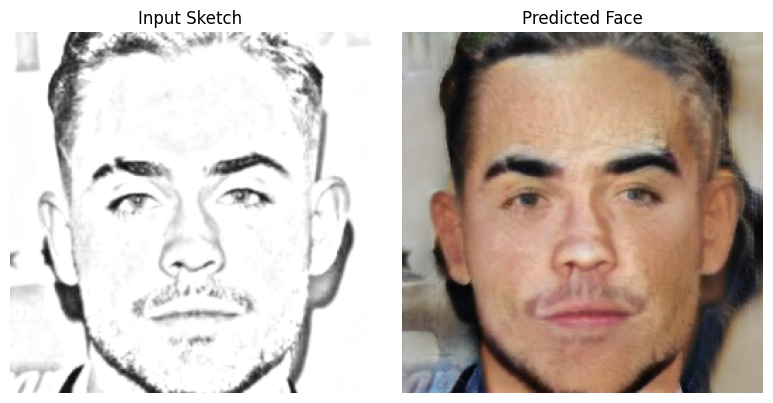

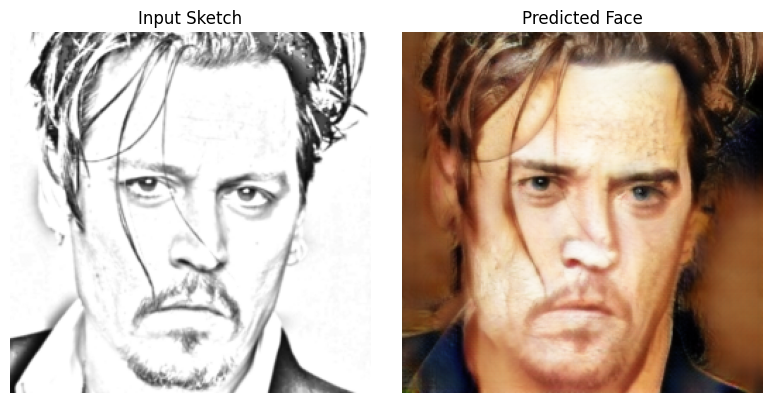

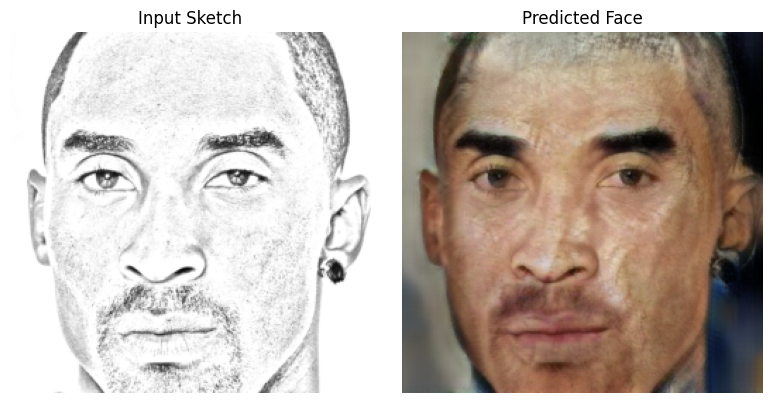

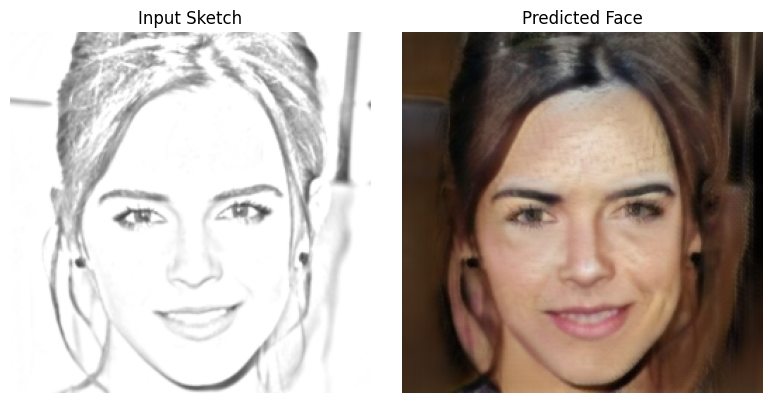

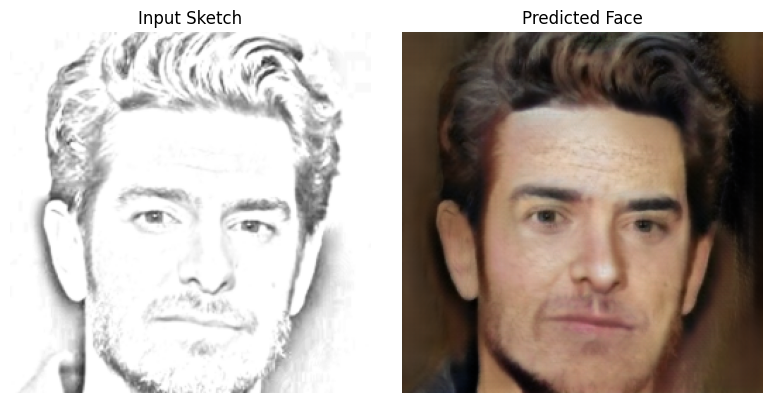

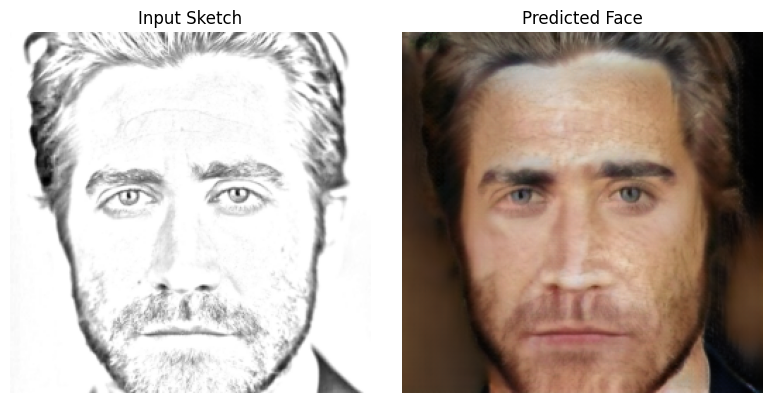

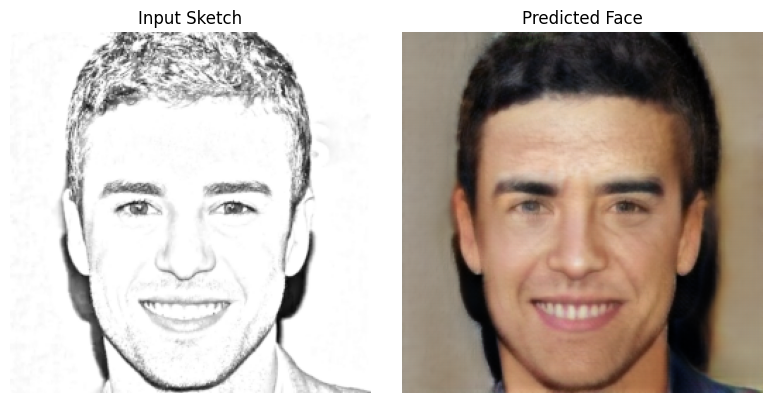

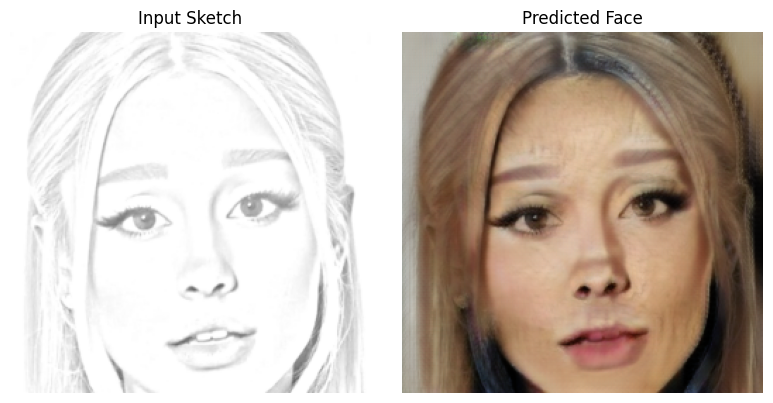

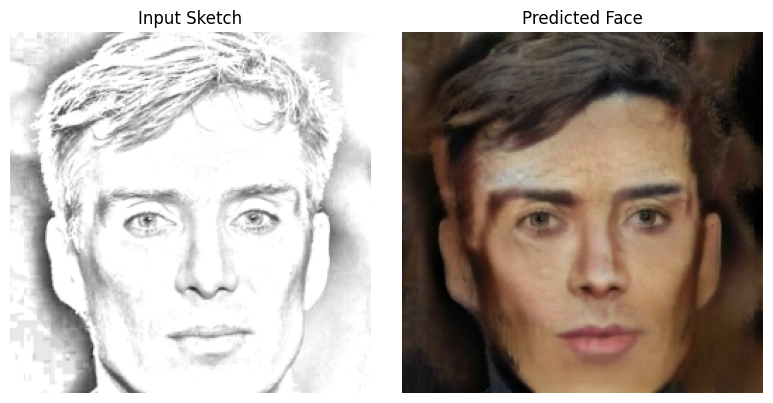

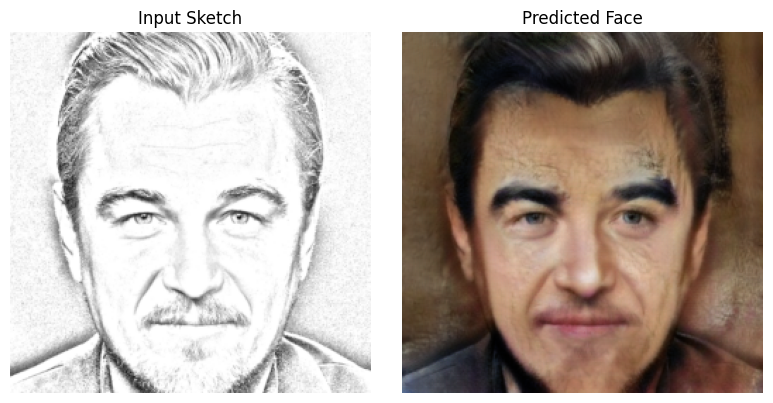

Prediction complete and images saved in /content/FS2K/test/predicted_faces


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

F.load_state_dict(torch.load("/content/drive/MyDrive/continued_cyclegan_checkpoints/F_epoch_27.pt", map_location=device))
F.eval()

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def denormalize(t):
    return t * 0.5 + 0.5

sketch_dir = "/content/FS2K/test/sketches"
photo_dir = "/content/FS2K/test/photos"

for filename in os.listdir(sketch_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        sketch_path = os.path.join(sketch_dir, filename)
        input_image = Image.open(sketch_path).convert("RGB")
        input_sketch = eval_transform(input_image).unsqueeze(0).to(device)

        with torch.no_grad():
            fake_face = F(input_sketch).squeeze(0).cpu()

        sketch_img = denormalize(input_sketch.squeeze(0).cpu()).permute(1, 2, 0).numpy()
        pred_img = denormalize(fake_face).permute(1, 2, 0).numpy()

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.title("Input Sketch")
        plt.imshow(sketch_img)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Face")
        plt.imshow(pred_img)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

print("Prediction complete and images saved in", output_dir)